# 1 - Data acquisition

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
data = pd.read_csv("bci05.csv")
data.head()

FileNotFoundError: [Errno 2] File b'bci05.csv' does not exist: b'bci05.csv'

In [ ]:
data = data[data["status"]=='A'][["tag", "sp", "gx", "gy"]]

In [ ]:
# 1) Species spotting
types = data['sp'].value_counts().keys() 
S = len(types)
print("There are {} different species".format(S))

# 2 - Statistics on subplots

Now we divide the total area of study (sampled plot) in 200 subplots of the same area.
To do so we add two columns to the dataset, called $i$ and $j$, that are the result of division without rest respectively of $gx$ and $gy$ for 50 (0.5 hectars in each axis). Then we use some methods of pandas to encode in a 3D matrix the aboundance $x_k$ of each of the S species for each subplot $(i,j)$ and from that we can obtain the average presence of each species.

In [3]:
# 2) Subsampling
# 50 * 50 meters
data["i"], data["j"] = data["gx"]//50, data["gy"]//50
# a)
cell_pop = data.groupby(["i", "j"])["sp"].value_counts()
# b) shaping them in a matrix
cell_pop_M = cell_pop.unstack().stack(dropna = False).fillna(0).astype(int)
cell_pop_M = np.array(cell_pop_M).reshape(20, 10, 299) # (i, j, specie)


# this prints are just for understanding how to work with this dataset
#print("Presence and aboundance in subplot (0,0) : \n", cell_pop_M[0,0,:], '\n')
#print("Aboundances of the various species: \n", cell_pop_M.sum(axis=(0,1)), '\n')

p_i = np.count_nonzero(cell_pop_M, axis = (0,1))/200
#print("Absolute presence for each species: \n", presence, '\n')
#print("Relative presence for each species: \n", p_i, '\n')

NameError: name 'data' is not defined

And the average squared difference between present and absent species in a subplot (that will be used as a constraint in section 4):

In [4]:
def pairing_p(configs):
    # In each subplot there are more absent species than present (just an observation)
    # S+ - S-
    S_present = np.count_nonzero(configs, axis = (1)).flatten()
    # S_absent = S - S_present -> S_pm = 2*S_present - S
    S_pm = 2*S_present - S # Broadcasting
    # constraint C_0 = < (S+ - S-)^2 >
    return np.mean(np.power(S_pm,2))


C_0_over_S = pairing_p(cell_pop_M.reshape(200, 299))/299
print(C_0_over_S)

NameError: name 'cell_pop_M' is not defined

## 3 - Max Ent 1

### Hamiltonian of the system for our constraints.

We start considering a generic entropy:

$$ S[\{p_a\}_{i=1,\ldots,n}] = -K \sum_{a=1}^n p_a ln(p_a), K > 0$$

and following constraints:

$$ \sum_{a=1}^n p_a - 1 = 0 $$

$$\sum_{a=1}^n  p_a f_r(x_a) - <f_r(x)>_{obs} = 0 $$

On the PDF we show that the corresponding Hamiltonian is:

$$H(x_a, \vec{\lambda}) = - \sum_{r=1}^{m}\lambda_i f_i(x_a)$$


### Analytical derivation of the tuned Lagrangian multipliers as functions of the constraints.

Adopting the notation to our specific model, we set $K=1$, and rename:

$x_a \rightarrow \vec{\sigma^{(a)}}, m \rightarrow S, f_r(x) \rightarrow \pi_i(\vec{\sigma}) = \sigma_i$

We start considering the following Hamiltonian:

$H(\vec{\sigma}, \vec{\lambda}) = - \sum_{i=1}^{S}\lambda_i f_i(\sigma) = - \sum_{i=1}^{S}\lambda_i \sigma_i $

Manipulating the partition function

$$Z(\vec{\lambda}) = \sum_{\{\vec{\sigma}\}} \exp\{\sum_{i=1}^S \lambda_i \sigma_i\} = \
    \sum_{\{\vec{\sigma}\}} \prod_{i=1}^S\exp\{\lambda_i \sigma_i\} = \
    \prod_{i=1}^S \sum_{\sigma_i = \pm 1} \exp\{\lambda_i \sigma_i\}  = \
    2^S \prod_{i=1}^S \cosh(\lambda_i)$$

Hence we can compute analytically the expected value for each variable $\sigma_i$ for a given value of $\vec{\lambda}$

$$ <\sigma_i>_{model(\vec{\lambda})} = \sum_{\{\vec{\sigma}\}} \sigma_i P(\vec{\sigma}/\vec{\lambda}) = \
\frac{\sum_{\sigma_i \pm 1} \sigma_i e^{\lambda_i \sigma_i}}{2 cosh(\lambda_i)} = tanh(\lambda_i) $$

Now we impose $\forall i$ $m_i = <\sigma_i>_{model(\vec{\lambda})}$ 

$m_i = tanh(\lambda_i) $

and inverting the system we find

$ \lambda_i = tanh^{-1}(m_i) = \frac{1}{2} \cdot ln(\frac{1 + m_i}{1 - m_i} )$

Here we apply the formula just obtained to compute the lagrangian parameters for the model Max Ent 1

In [97]:
m_i = 2*p_i - 1
print(m_i.max(), m_i.min())
# PROBLEM: too much variance depending on epsilon...
eps = 0
l_i = np.arctanh(m_i- np.sign(m_i)*eps) # same function
print(l_i.max(),l_i.min())

1.0 -0.99
inf -2.6466524123622457


/home/nicola/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in arctanh
  """


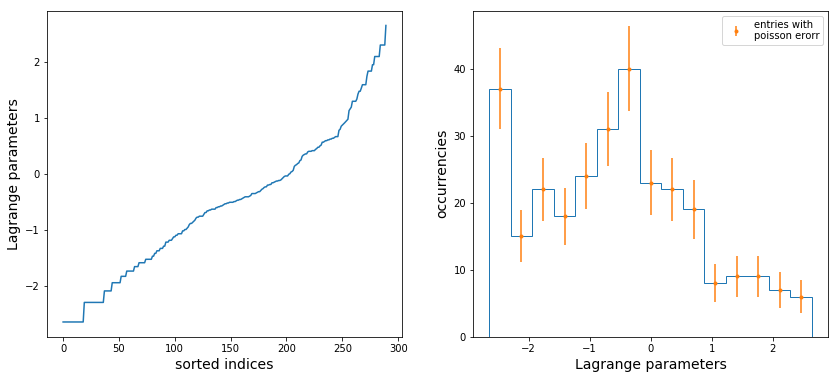

In [26]:
# first we remove from the plots the infinite eigenvalues
l_i_sorted = l_i[np.isfinite(l_i)]
# then we sort the remaining one for the first plot
l_i_sorted.sort()

fig, ax = plt.subplots(ncols=2, figsize=(14, 6))
# left panel
ax[0].plot(l_i_sorted)
ax[0].set_xlabel("sorted indices", fontsize = 14)
ax[0].set_ylabel("Lagrange parameters", fontsize = 14)
# right panel
counts, bin_extremes1, _ = ax[1].hist(l_i_sorted, bins = 15, histtype = 'step', density = False)
bin_centers1 = (bin_extremes1[1:] + bin_extremes1[:-1])/2
ax[1].errorbar(bin_centers1, counts, np.sqrt(counts), fmt = '.', label = 'entries with \npoisson erorr')
ax[1].set_xlabel("Lagrange parameters", fontsize = 14)
ax[1].set_ylabel("occurrencies", fontsize = 14)
plt.legend()
plt.show()

## Theoric estimate of the parameters

$$K = -\frac{1}{2}\frac{S}{Var(M)_{obs}} \\ \lambda_i = tanh^{-1}(m_i) + \frac{<M>_{obs}}{Var(M)_{obs}}$$

In [98]:
# total magnetization
M = m_i.mean()
# variance of the magnetization
VM = m_i.var()
#
K = -0.5*S/VM
print(K)
# saddle-point lambda_i - there is again the problem with regularization for m_i = +/- 1
eps = 10**-6
sp_l_i = np.arctanh(m_i - np.sign(m_i)*eps) + M/VM
print(sp_l_i.max(), sp_l_i.min())

-308.40042553350946
6.722188602438023 -3.1787421804153793


## 4 - Max Ent 2

Now we consider a new Hamiltonian

$H(\vec{\sigma}, \vec{\lambda}, K) = - \frac{K}{S}\sum_{i,j}\sigma_i\sigma_j - \sum_{i=1}^{S}\lambda_i \sigma_i$



### Constraints for Max Ent 2

The constraints that we are going to use are:
* $m_i = <\sigma_i>_{model} = C_i(\vec{\sigma}) $ with coupled parameters $\lambda_i, i = 1,\ldots, S$
* $\frac{<(S_+ - S_-)^2>_{exp}}{S} = \frac{<(\sum_{j=1}^{S}\sigma_j)^2>_{model}}{S} = \frac{C_0(\vec{\sigma})}{S}$ with coupled parameter $\lambda_0 = K$

To initialize the Lagrange multipliers we have two possible choices: extracting them from a gaussian distribution centered in 0 or to take the initial $\lambda_i$ as the one of the previous point and for $K'$ using a gaussian with variance that is a funtion of S. [WORK IN PROGRESS]

### Gradient descent function

The objective function that we want to minimize is the Kullback–Leibler divergence $D_{KL}(P_{exp}/P_{model})$.

The derivatives of the KL-divergence w.r.t. the Lagrangian multipliers are:

$$ \frac{\partial D_{KL}}{\partial \lambda_a} = <C_a(\vec{\sigma})>_{model}-<C_a(\vec{\sigma})>_{exp} $$

More in concrete:

$$\frac{\partial D_{KL}(t)}{\partial \lambda_0} = \frac{<(\sum_{j=1}^{S}\sigma_j)^2>_{model(t)}}{S} - \frac{<(S_+ - S_-)^2>_{exp}}{S}  $$

$$\frac{\partial D_{KL}(t)}{\partial \lambda_i} = <\sigma_i>_{model(t)} - m_i $$


Thus the update rule for gradient descent will be:

$$\lambda_a(t+1) \leftarrow \lambda_a(t) - \eta \cdot \frac{\partial D_{KL}(t)}{\partial \lambda_a}$$


### Stopping criteria
Then we want to run the cycle of Metropolis and gradient descent until a stopping criteria is met.
Possible choices are:
* fixed number of iterations
* margin of improvement under a certain threshold

In [163]:
def gradient(model_configs, exp_constraints):
    update1 = pairing_vec(model_configs) - exp_constraints[0]
    print("Model constraint C_0: ", pairing_vec(model_configs))
    print("Observed constraint C_0: ", exp_constraints[0])
    update2 = model_m(model_configs) - exp_constraints[1:]
    
    #update2 = model_m(model_configs) - exp_constraints    
    gradient = np.concatenate((update1[np.newaxis], update2))
    return gradient

def adam(grad, m, s, beta1=0.9, beta2=0.99, e=1e-8):
    # m = momentum = 0.9 last_m + 0.1 new_gradient
    m = beta1*m+(1-beta1)*grad
    # s = second moment = 0.99 last_s + 0.01 new_gradient**2 (elementwise?)
    s = beta2*s+(1-beta2)*(grad**2)
    m_c = m/(1-beta1)
    s_c = s/(1-beta2)
    # return new_m, new_s and adam_gradient
    return m, s, (m_c/np.sqrt(s_c+e))

In [164]:
def pairing(configs):
    return np.power(configs.sum(),2)/S

def pairing_vec(configs):
    #print("Configs shape (n,S): ", configs.shape)
    Spm = configs.sum(axis=1)
    #print("Summing over i for each config: (n)", Spm.shape)
    mean_Spm = Spm.mean()
    return np.power(mean_Spm,2)/S

def model_m(configs):
    # assuming configs have a shape of (n, S) with S = 299
    return configs.mean(axis=0)


def compute_energy(config, L_multipliers):
    """Computes the energy of a configuration."""
    model_pair = pairing(config) # C_0/S
    #model_m_i = model_m(configs)
    model_parameters = np.concatenate((model_pair[np.newaxis], config))
    # L_multipliers[0] = K
    return -np.dot(model_parameters[1:], L_multipliers[1:]) - model_parameters[0]*L_multipliers[0]


In [165]:
def METRO(lagrange_multipliers, M=1e4, N=100):
    configs = []
    configuration = np.random.choice([+1,-1], size = 299)
    flip_spins = np.random.randint(low = 0, high = 299, size = int(M))
    for index in flip_spins:
        new = np.copy(configuration) # !!!!!!!
        new[index] = -configuration[index] # !!!!!!!
        #print(new[index], configuration[index]) flipping works
        if acceptance(new, configuration, lagrange_multipliers):     # !!!!!
            configuration = new
            configs.append(configuration)    
    return np.array(configs[-N:])

def acceptance(new, old, lagrange_multipliers):
    """Implements Metropolis choice."""
    # regularizer?
    en1 = compute_energy(new, lagrange_multipliers)
    en2 = compute_energy(old, lagrange_multipliers)

    if  (en1-en2) < 0:
        #print("New energy: ", en1) - high and always negative, but seems to work
        return True
    else:
        P = np.random.random()
        if P < np.exp(-(en1-en2)): #in teoria no <------------------- BETA?
            #print("New energy: ", en1) -  high and always negative, but seems to work
            return True
        else:
            return False


In [168]:

# Hyperparameters

# and the number of iterations
max_iter = 300

#suppression = np.arange(1,max_iter+1)
# the learning rate
etas = 0.1

#lagrange_multipliers = np.concatenate((np.array([K]), sp_l_i))
lagrange_multipliers = np.random.randn(300)
print("Theorical K: ", K)
exp_constraints = np.concatenate((C_0_over_S[np.newaxis], m_i))
print(lagrange_multipliers[0]*exp_constraints[0])
mean_sq_loss = np.zeros(max_iter) # gradient square sum
m = 0; s=0

from tqdm import tnrange
for i in tnrange(max_iter):
    configs = METRO(lagrange_multipliers)
    g = gradient(configs, exp_constraints)
    print("First component of g:", g[0])
    m, s, update = adam(g, m, s)
    print("First component of adams:", update[0])
    lagrange_multipliers = lagrange_multipliers - eta*update
    print("K : ", lagrange_multipliers[0])
    #lagrange_multipliers[0] = lagrange_multipliers[0] - eta*update[0]
    #lagrange_multipliers[1:] = lagrange_multipliers[1:] - eta*update[1:]
    #gradients.append(g[:])
    #print(update[0])
    #print(lagrange_multipliers[0])
    #print(g[0])
    mean_sq_loss[i] = np.power(g,2).sum()
    print("Squared gradient: ", mean_sq_loss[i])


Theorical K:  -308.40042553350946
0.9901929792346332


Model constraint C_0:  0.5617444816053513
Observed constraint C_0:  21.32829431438127
First component of g: -20.76654983277592
First component of adams: -0.9999999999884058
K :  0.05642626197091118
Squared gradient:  856.4142919571656
Model constraint C_0:  0.2589966555183947
Observed constraint C_0:  21.32829431438127
First component of g: -21.069297658862876
First component of adams: -1.3473030067342253
K :  0.06989929203825343
Squared gradient:  866.9860038377649
Model constraint C_0:  0.016187290969899668
Observed constraint C_0:  21.32829431438127
First component of g: -21.31210702341137
First component of adams: -1.573675983865488
K :  0.08563605187690831
Squared gradient:  876.6638057773403
Model constraint C_0:  0.0015464882943143816
Observed constraint C_0:  21.32829431438127
First component of g: -21.326747826086958
First component of adams: -1.7341958665359598
K :  0.1029780105422679
Squared gradient:  902.7552728375048
Model constraint C_0:  0.032556521739130435
Observed co

Model constraint C_0:  24.712781270903005
Observed constraint C_0:  21.32829431438127
First component of g: 3.3844869565217337
First component of adams: -0.7740594678276084
K :  0.6746316809663028
Squared gradient:  305.80265195886574
Model constraint C_0:  19.460329096989966
Observed constraint C_0:  21.32829431438127
First component of g: -1.8679652173913048
First component of adams: -0.7195251930314353
K :  0.6818269328966171
Squared gradient:  330.28399405338376
Model constraint C_0:  41.088647491638795
Observed constraint C_0:  21.32829431438127
First component of g: 19.760353177257524
First component of adams: -0.4343345347075032
K :  0.6861702782436921
Squared gradient:  684.1802576899515
Model constraint C_0:  90.43650033444816
Observed constraint C_0:  21.32829431438127
First component of g: 69.10820602006689
First component of adams: 0.2609175259497257
K :  0.6835611029841949
Squared gradient:  5086.030839312009
Model constraint C_0:  39.24154648829431
Observed constraint C_0

Model constraint C_0:  47.32936989966555
Observed constraint C_0:  21.32829431438127
First component of g: 26.00107558528428
First component of adams: 0.03849310557774399
K :  0.6413887514568797
Squared gradient:  909.1910315916663
Model constraint C_0:  36.84482140468227
Observed constraint C_0:  21.32829431438127
First component of g: 15.516527090301
First component of adams: 0.1473443134124825
K :  0.6399153083227549
Squared gradient:  469.1705129440449
Model constraint C_0:  11.70536989966555
Observed constraint C_0:  21.32829431438127
First component of g: -9.62292441471572
First component of adams: 0.06284746727349988
K :  0.6392868336500199
Squared gradient:  371.3373742913319
Model constraint C_0:  52.96222608695653
Observed constraint C_0:  21.32829431438127
First component of g: 31.633931772575256
First component of adams: 0.28102130934403874
K :  0.6364766205565795
Squared gradient:  1223.4559393919462
Model constraint C_0:  32.19911170568562
Observed constraint C_0:  21.328

Model constraint C_0:  24.36899531772575
Observed constraint C_0:  21.32829431438127
First component of g: 3.0407010033444806
First component of adams: 0.1453619107420587
K :  0.5730127559171498
Squared gradient:  220.02376259174014
Model constraint C_0:  15.410349163879596
Observed constraint C_0:  21.32829431438127
First component of g: -5.917945150501675
First component of adams: 0.09118414439677544
K :  0.5721009144731821
Squared gradient:  239.6027748043463
Model constraint C_0:  17.959727090301005
Observed constraint C_0:  21.32829431438127
First component of g: -3.368567224080266
First component of adams: 0.05946903657862442
K :  0.5715062241073958
Squared gradient:  228.3551451431478
Model constraint C_0:  15.683981270903011
Observed constraint C_0:  21.32829431438127
First component of g: -5.64431304347826
First component of adams: 0.015067583410638094
K :  0.5713555482732895
Squared gradient:  218.8229697327788
Model constraint C_0:  9.508436120401337
Observed constraint C_0:

Model constraint C_0:  40.85174046822742
Observed constraint C_0:  21.32829431438127
First component of g: 19.523446153846148
First component of adams: 0.12714840103365782
K :  0.5610642196346979
Squared gradient:  569.87884972213
Model constraint C_0:  10.988569899665553
Observed constraint C_0:  21.32829431438127
First component of g: -10.339724414715718
First component of adams: 0.04263328482920568
K :  0.5606378867864058
Squared gradient:  299.94980097226835
Model constraint C_0:  29.376048160535113
Observed constraint C_0:  21.32829431438127
First component of g: 8.047753846153842
First component of adams: 0.0947957560967423
K :  0.5596899292254384
Squared gradient:  230.09224196828396
Model constraint C_0:  17.940125752508358
Observed constraint C_0:  21.32829431438127
First component of g: -3.388168561872913
First component of adams: 0.06190895509358966
K :  0.5590708396745024
Squared gradient:  198.17758620366396
Model constraint C_0:  3.0503010033444813
Observed constraint C_0

Model constraint C_0:  21.44751304347826
Observed constraint C_0:  21.32829431438127
First component of g: 0.11921872909698905
First component of adams: 0.0004220053220418783
K :  0.5709460554461744
Squared gradient:  167.6157131053675
Model constraint C_0:  41.207357859531776
Observed constraint C_0:  21.32829431438127
First component of g: 19.879063545150505
First component of adams: 0.14857847724407727
K :  0.5694602706737336
Squared gradient:  567.4642674321317
Model constraint C_0:  38.98114247491638
Observed constraint C_0:  21.32829431438127
First component of g: 17.65284816053511
First component of adams: 0.26435913390301774
K :  0.5668166793347035
Squared gradient:  462.3241481789078
Model constraint C_0:  28.926421404682273
Observed constraint C_0:  21.32829431438127
First component of g: 7.598127090301002
First component of adams: 0.29537019819692717
K :  0.5638629773527342
Squared gradient:  242.80583528036595
Model constraint C_0:  12.024085618729098
Observed constraint C_

Model constraint C_0:  38.6352856187291
Observed constraint C_0:  21.32829431438127
First component of g: 17.30699130434783
First component of adams: -0.12617346777445823
K :  0.5597119317097498
Squared gradient:  441.24024800877135
Model constraint C_0:  39.44468227424749
Observed constraint C_0:  21.32829431438127
First component of g: 18.11638795986622
First component of adams: 0.029265481630638253
K :  0.5594192768934434
Squared gradient:  460.2918127123858
Model constraint C_0:  37.35204816053512
Observed constraint C_0:  21.32829431438127
First component of g: 16.02375384615385
First component of adams: 0.15170152105936194
K :  0.5579022616828497
Squared gradient:  409.0257873221304
Model constraint C_0:  7.8217043478260875
Observed constraint C_0:  21.32829431438127
First component of g: -13.506589966555183
First component of adams: 0.03077938350043511
K :  0.5575944678478454
Squared gradient:  339.9150725246491
Model constraint C_0:  11.034627424749164
Observed constraint C_0: 

Model constraint C_0:  27.695652173913043
Observed constraint C_0:  21.32829431438127
First component of g: 6.367357859531772
First component of adams: -0.2475840575779987
K :  0.5740163564913625
Squared gradient:  168.02594611134106
Model constraint C_0:  23.129048829431436
Observed constraint C_0:  21.32829431438127
First component of g: 1.8007545150501656
First component of adams: -0.20854813347604978
K :  0.576101837826123
Squared gradient:  129.19581682347356
Model constraint C_0:  18.018595317725755
Observed constraint C_0:  21.32829431438127
First component of g: -3.3096989966555164
First component of adams: -0.21694970831116403
K :  0.5782713349092347
Squared gradient:  132.58360744846254
Model constraint C_0:  9.723633444816056
Observed constraint C_0:  21.32829431438127
First component of g: -11.604660869565215
First component of adams: -0.2948001285834752
K :  0.5812193361950694
Squared gradient:  260.7032538976181
Model constraint C_0:  8.174961872909698
Observed constraint

Model constraint C_0:  39.910961872909695
Observed constraint C_0:  21.32829431438127
First component of g: 18.582667558528424
First component of adams: -0.039208521173728576
K :  0.6113002851603885
Squared gradient:  447.67383359078474
Model constraint C_0:  36.73257525083612
Observed constraint C_0:  21.32829431438127
First component of g: 15.40428093645485
First component of adams: 0.09468230468776032
K :  0.6103534621135108
Squared gradient:  359.92737116922626
Model constraint C_0:  28.82697525083612
Observed constraint C_0:  21.32829431438127
First component of g: 7.49868093645485
First component of adams: 0.14887042883962315
K :  0.6088647578251146
Squared gradient:  166.7877157867514
Model constraint C_0:  29.728155183946487
Observed constraint C_0:  21.32829431438127
First component of g: 8.399860869565217
First component of adams: 0.2055119070423479
K :  0.6068096387546912
Squared gradient:  197.24316262805291
Model constraint C_0:  17.434247491638796
Observed constraint C_0:

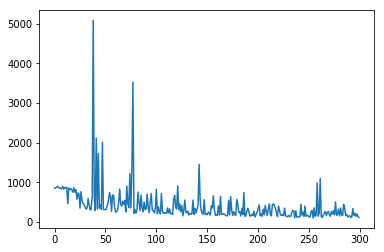

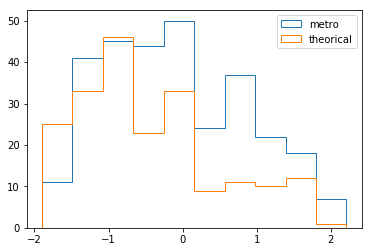

In [172]:
plt.plot(mean_sq_loss)
plt.show()
#bk = np.concatenate((np.array([K]), sp_l_i))
#l = np.power(lagrange_multipliers-bk,2)
#print(l)
n, bins, _ = plt.hist(lagrange_multipliers[1:], histtype = 'step', label = 'metro')
plt.hist(sp_l_i, bins = bins, histtype = 'step', label = 'theorical')
plt.legend()
plt.show()
#gradients = np.array(gradients[-100:]).flatten()
#plt.hist(gradients)
#plt.show()

## 6 - Max Ent 3

$ H = \sum_{i=1}^S \lambda_i x_i + \frac{1}{2}\sum_{i,j=1}^S M_{ij}x_i x_j$

$M_{ij}^{-1} = Cov(x_i,x_j)_{emp}$

$\lambda_i = - \sum_{j=1}^S M_{ij}x_j$

First of all we consider the matrix X of all the aboundances for all the subplots. It is a matrix of N rows and S columns.

In [28]:
X = cell_pop_M.reshape((200,299))

Then we compute for each species the mean and the standard deviation

In [29]:
x_mean = X.mean(axis = 0)
x_std = X.std(axis = 0)

We keep only those species that satisfy:

$<x_i>_{emp} - \sigma_{x_i} > 0$

In [30]:
aboundance_mask = x_mean - x_std > 0 
X_most_ab = X[:,aboundance_mask]

In this way we reduce the number of species from 299 to 52:

In [31]:
print(X_most_ab.shape[1])

52


Now we compute the inverse of the interaction matrix M as the covariance matrix of the abundances of the selected species and from that we obtain M inverting $M^{-1}$

In [32]:
inv_M = np.cov(X_most_ab.T)
M = np.linalg.inv(inv_M)

We now impose that the self interacting terms (diagonal) are null

In [33]:
mask = np.eye(M.shape[0]).astype('bool')
M[mask] = 0
print(M.trace())

0.0


In [34]:
print("Max interaction element: %.3f"%M.max())
print("Min interaction element: %.3f"%M.min())

Max interaction element: 0.176
Min interaction element: -0.093


At this point we can compute $\lambda_i$ with the formula reported at the begin of this section

In [35]:
X_most_mean = X_most_ab.mean(axis = 0)
lamb = -np.dot(M,X_most_mean)
#plt.hist(lamb)
#plt.show()
#plt.close()

# 7 - Analysis of the interaction network

In this first histogram we can see the distribuition of the entries of the matrix $M$. We can notice that the distribution is peaked around the zero (with a number of entries much higher than the length of the diagonal, i.e. ~600 vs 52) and it is more or less symmetric around zero.

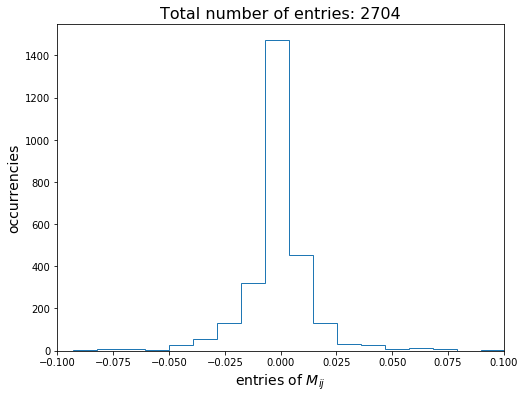

In [48]:
plt.figure(figsize = (8,6))
plt.hist(M.flatten(), bins = 25, histtype = 'step', density = False)
plt.xlim(-0.10, +0.10)
plt.xlabel("entries of $M_{ij}$", fontsize = 14)
plt.ylabel("occurrencies", fontsize = 14)
plt.title("Total number of entries: %d"%(len(M)**2), fontsize = 16)
plt.show()

Now we want to put a threshold $\theta$ on the absolute value of the entries of M. We choose as range for the threshold $[0,max(abs(M))]$

In [37]:
def laplacian(A):
    degrees = A.sum(axis = 0)
    K = np.diag(degrees)
    return K-A

In [38]:
# number of threshold we want to use
T = 2000
# consider evenly spaced thresholds
thresholds = np.linspace(0, np.max(np.abs(M)), T)
# placehholder for the number of connected components for each threshold
connected_components = np.zeros(T)
# this is the order of magnitude under which we consider zero an eigenvalue
sensibility = 10**-12 
#OBS: it can't be taken too small otherwise it would count 0 connected components for theta = 0, that is absurd

for i,theta in enumerate(thresholds):
    # elementwise boolean operation, returns a matrix of True and False
    threshold_mask = np.abs(M) > theta 
    # we can compute directly the adjacency matrix from the threshold mask
    A = threshold_mask.astype(int)
    # compute the laplacian of A
    L = laplacian(A)
    # eigenvalue decomposition; "eigh" used for symmetric matrix -> default format fo eigenvalues is set to float
    eig_values,V = np.linalg.eigh(L)
    # we take as zero all the eigenvalues with absolute value under the chosen sensibility 
    almost_zero = np.abs(eig_values) < sensibility
    # number of conncected components = number of zero eigenvalues (or equivalently degeneracy of eigval 0)
    connected_components[i] = np.count_nonzero(almost_zero.astype(int))

In [52]:
one_component_mask = connected_components == 1
theta_star = np.max(thresholds[one_component_mask])
print("Estimated theta star: %.4f"%theta_star)

Estimated theta star: 0.0031


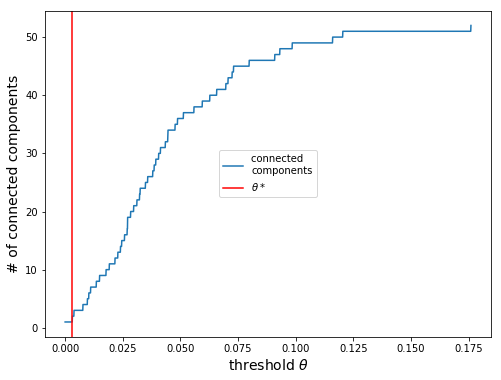

In [59]:
plt.figure(figsize = (8,6))
plt.plot(thresholds, connected_components, label = 'connected \ncomponents')
plt.xlabel("threshold "+r"$\theta$", fontsize = 14)
plt.ylabel("# of connected components", fontsize = 14)
plt.axvline(theta_star, color = 'red', label = r'$\theta*$')
plt.legend(loc = 'center')
plt.show()

In [41]:
# if we are interested in the detailed correspondence between threshold and connected components
for t,c in zip(thresholds, connected_components):
    print("Threshold = %.4f, connected components = %.d"%(t,c))

Threshold = 0.0000, connected components = 1
Threshold = 0.0001, connected components = 1
Threshold = 0.0002, connected components = 1
Threshold = 0.0003, connected components = 1
Threshold = 0.0004, connected components = 1
Threshold = 0.0004, connected components = 1
Threshold = 0.0005, connected components = 1
Threshold = 0.0006, connected components = 1
Threshold = 0.0007, connected components = 1
Threshold = 0.0008, connected components = 1
Threshold = 0.0009, connected components = 1
Threshold = 0.0010, connected components = 1
Threshold = 0.0011, connected components = 1
Threshold = 0.0011, connected components = 1
Threshold = 0.0012, connected components = 1
Threshold = 0.0013, connected components = 1
Threshold = 0.0014, connected components = 1
Threshold = 0.0015, connected components = 1
Threshold = 0.0016, connected components = 1
Threshold = 0.0017, connected components = 1
Threshold = 0.0018, connected components = 1
Threshold = 0.0018, connected components = 1
Threshold 

Threshold = 0.1480, connected components = 51
Threshold = 0.1481, connected components = 51
Threshold = 0.1482, connected components = 51
Threshold = 0.1483, connected components = 51
Threshold = 0.1483, connected components = 51
Threshold = 0.1484, connected components = 51
Threshold = 0.1485, connected components = 51
Threshold = 0.1486, connected components = 51
Threshold = 0.1487, connected components = 51
Threshold = 0.1488, connected components = 51
Threshold = 0.1489, connected components = 51
Threshold = 0.1490, connected components = 51
Threshold = 0.1491, connected components = 51
Threshold = 0.1491, connected components = 51
Threshold = 0.1492, connected components = 51
Threshold = 0.1493, connected components = 51
Threshold = 0.1494, connected components = 51
Threshold = 0.1495, connected components = 51
Threshold = 0.1496, connected components = 51
Threshold = 0.1497, connected components = 51
Threshold = 0.1498, connected components = 51
Threshold = 0.1498, connected comp

In [42]:
import networkx as nx

In [43]:
threshold_mask = np.abs(M) > theta_star
# this is the adjacency matrix that we are going to use for our analysis
A_star = threshold_mask.astype(int)

Analyze the structural properties of W * (degree distribution, diameter, clustering, degree assortativity, betweeness centrality). In what respect, if any, the graph is different from a random ER graph?

Mean degree: 30.42
Degree standard deviation: 10.28


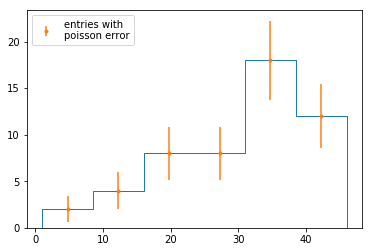

In [44]:
K = A_star.sum(axis = 0)
print("Mean degree: %.2f"% K.mean())
print("Degree standard deviation: %.2f"% K.std())
# not having much elements for a graphs we prefer to use a small amount of bins 
# in order to capture less information but more reliable
entries, bin_extremes, _ = plt.hist(K, bins = 6, histtype = 'step')
bin_centers = (bin_extremes[1:] + bin_extremes[:-1])/2
plt.errorbar(bin_centers, entries, yerr = np.sqrt(entries), fmt = '.', label = 'entries with \npoisson error')
plt.legend(loc = "upper left")
plt.show()

Using the networkx library we can easily compute most of the quantities of interest.

In [45]:
G = nx.from_numpy_matrix(A_star)

D = nx.diameter(G)
print("Diameter of the network: ", D)

# local clustering for each node
c_i_dict = nx.clustering(G)
n_nodes = len(G)
c_i = np.zeros(n_nodes)
for i in range(n_nodes):
    c_i[i] = c_i_dict[i]
    
# global clustering
C = c_i.mean()
print("Global clustering coefficient: %.2f"% C)

deg_assortativity = nx.degree_assortativity_coefficient(G)
print("Degree assortativity: %.2f"%deg_assortativity)

btw_centrality = nx.betweenness_centrality(G)
b_c = np.zeros(n_nodes)
for i in range(n_nodes):
    b_c[i] = btw_centrality[i]
print("Max beetweenness centrality: %.2f"%b_c.max())

Diameter of the network:  3
Global clustering coefficient: 0.73
Degree assortativity: -0.24
Max beetweenness centrality: 0.05


We can compare these results with the one that we would find in an Erdosh-Reny graph with the same number of nodes and with probability of connecting two nodes given by $p = \frac{<k>}{n-1}$, where $<k>$ is the observed average degree of $A^*$. To do this, we consider an ensamble of E-R graphs in order to compute the estimated quantities and not the one of a single realization.

In [46]:
p = K.mean()/(n_nodes-1)
graphs_number = 100

# we are going to store in the following arrays all the results for each single ER graph 
# and then make a statistic out of them
ER_k_std_devs = np.zeros(graphs_number)
ER_diameters = np.zeros(graphs_number)
ER_cluster_coeffs = np.zeros(graphs_number)
ER_deg_assortativities = np.zeros(graphs_number)
ER_max_btw_centralities = np.zeros(graphs_number)


for i in range(graphs_number):
    # create an Erdosh-Reny graph
    ERG = nx.gnp_random_graph(n_nodes,p)
    # compute the degree standard deviation
    degs_dict = ERG.degree()
    degs = np.zeros(n_nodes)
    for j in range(n_nodes):
        degs[j] = degs_dict[j]
    ER_k_std_devs[i] = degs.std()
    
    ER_diameters[i] =  nx.diameter(ERG)
    
    c_i_dict = nx.clustering(ERG)
    c_i = np.zeros(n_nodes)
    for j in range(n_nodes):
        c_i[j] = c_i_dict[j]

    # global clustering
    ER_cluster_coeffs[i] = c_i.mean()

    ER_deg_assortativities[i] = nx.degree_assortativity_coefficient(ERG)

    btw_centrality = nx.betweenness_centrality(ERG)
    b_c = np.zeros(n_nodes)
    for j in range(n_nodes):
        b_c[j] = btw_centrality[j]
    ER_max_btw_centralities[i] = b_c.max()

print("Degree standard deviation: %.2f"% ER_k_std_devs.mean())
print("Diameter of the network: %.2f" % ER_diameters.mean())
print("Global clustering coefficient: %.2f"% ER_cluster_coeffs.mean())
print("Degree assortativity: %.2f"%ER_deg_assortativities.mean())
print("Max beetweenness centrality: %.2f"%ER_max_btw_centralities.mean())

Degree standard deviation: 3.37
Diameter of the network: 2.00
Global clustering coefficient: 0.60
Degree assortativity: -0.04
Max beetweenness centrality: 0.01


Confronting the results of the real network with the ensamble of ER graphs:

| Quantity | Real graph | ER graph|
| --- | --- | --- |
| degree std dev | 10.28 | 3.38 |
| diameter | 3 | 2.00 |
| clustering | 0.73| 0.59 |
| assortativity | -0.24 | -0.04 |
| max centrality | 0.05 | 0.01 |

We can see that none of these quantities is too similar between the two kinds of graphs. 

More precisely we can conclude that our network:
* presents a much higher variance in the degree distribution;
* has a larger diameter (ER diameter being 2.00 for a hundred graphs imply that none of them has diameter equal 3!);
* has a higher clustering coefficient;
* has a disassortative behaviour w.r.t. the almost neutral one of the ER ensamble;
* has a central node with a betweenness centrality that is 5 times higher than the "central" node of ER graphs.

All this suggests that the network of the species has an underlying structure that is not random, but possibly depends on the "microscopic" details of each species.

NOTE: ER results could vary a bit because we don't have a fixed seed for their generator.